In [2]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.metrics import Recall, Precision
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from keras.applications import DenseNet121  
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras import layers
import tensorflow as tf
import multiprocessing
from keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Input, Lambda
import cv2

In [3]:
# Define the path to the data directory
data_dir = "C:/Users/HP/Desktop/crimp cross section classifier/Enhancing-Quality-Inspection-in-Automotive-Manufacturing-through-Deep-Learning-and-Transfer-Learning/data/terminal-data"
sample= "C:/Users/HP/Desktop/crimp cross section classifier/Enhancing-Quality-Inspection-in-Automotive-Manufacturing-through-Deep-Learning-and-Transfer-Learning/sample"
# Define the paths to the train and test directories
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define the input image size and number of classes
img_width = 224
img_height = 224
batch_size = 8

In [4]:
def visualize_data(train_dir, val_dir, test_dir):
    train_counts = []
    val_counts = []
    test_counts = []
    labels = []

    for folder in os.listdir(train_dir):
        labels.append(folder)
        train_counts.append(len(os.listdir(os.path.join(train_dir, folder))))

    for folder in os.listdir(val_dir):
        val_counts.append(len(os.listdir(os.path.join(val_dir, folder))))

    for folder in os.listdir(test_dir):
        test_counts.append(len(os.listdir(os.path.join(test_dir, folder))))

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width, train_counts, width, label='Train')
    rects2 = ax.bar(x, val_counts, width, label='Validation')
    rects3 = ax.bar(x + width, test_counts, width, label='Test')

    ax.set_ylabel('Number of Images')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()


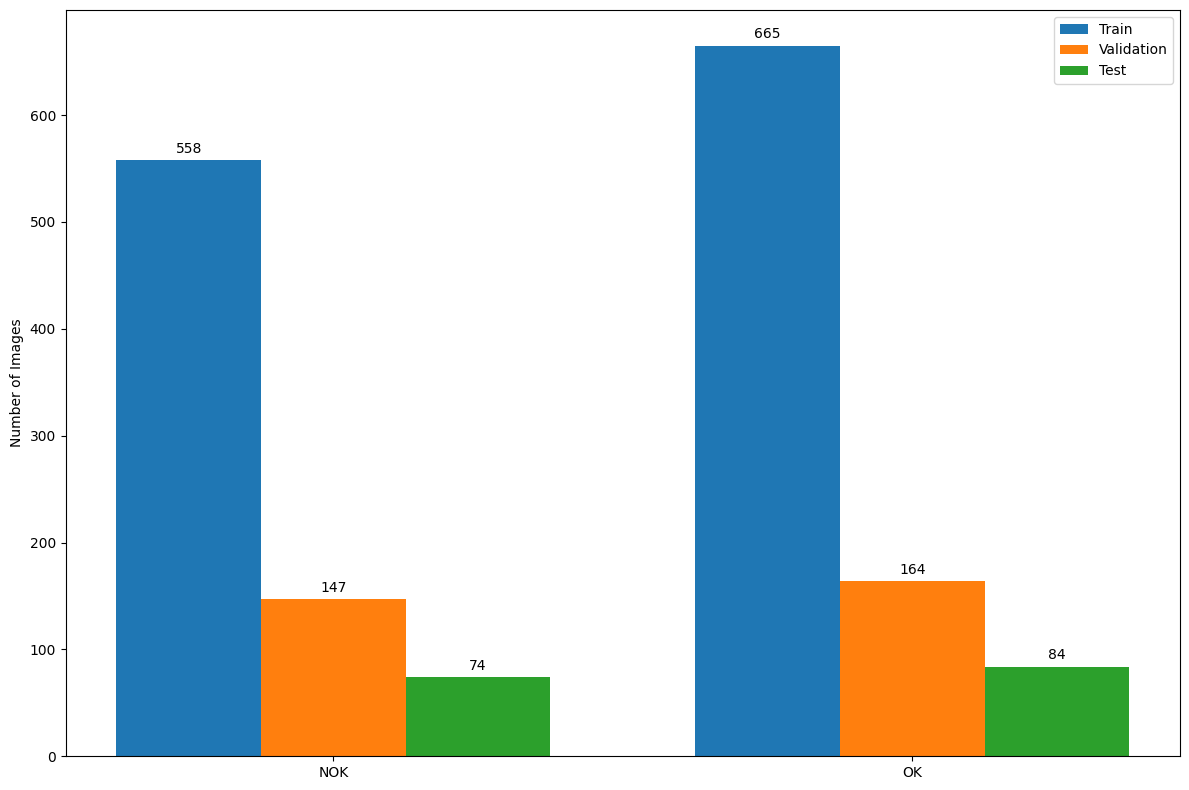

In [5]:
visualize_data(train_dir, val_dir, test_dir)

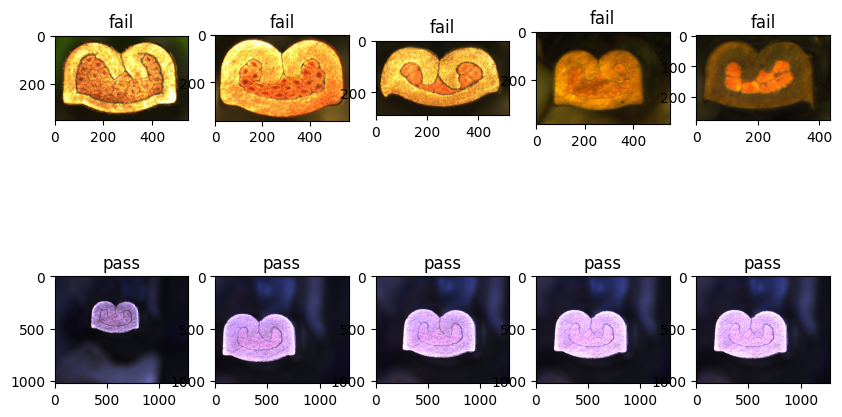

In [6]:
# Define the paths to the train directories for the "fail" and "pass" classes
fail_train_dir = os.path.join(data_dir, "train", "NOK")
pass_train_dir = os.path.join(data_dir, "train", "OK")

# Define the paths to a few images from each class
fail_images = [os.path.join(fail_train_dir, f) for f in os.listdir(fail_train_dir)[:5]]
pass_images = [os.path.join(pass_train_dir, f) for f in os.listdir(pass_train_dir)[:5]]

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))

for i, image_path in enumerate(fail_images):
    ax = axes[0, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("fail")

for i, image_path in enumerate(pass_images):
    ax = axes[1, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("pass")

plt.show()

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # rescales the pixel values to the range [0, 1]
    brightness_range=(0.8, 1.5),  # randomly adjusts the brightness of the images by a factor between 0.8 and 1.2
    #shear_range=0.2,  # randomly applies shearing transformations to the images
    #zoom_range=0.1,  # randomly applies zooming transformations to the images
    fill_mode='nearest',  # fills in a 
    #width_shift_range=0.1,  # randomly shifts images horizontally
    #height_shift_range=0.1, # randomly shifts images vertically
    )

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 1223 images belonging to 2 classes.


In [8]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 311 images belonging to 2 classes.


In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    shuffle = False,
    seed=42
    )

Found 158 images belonging to 2 classes.


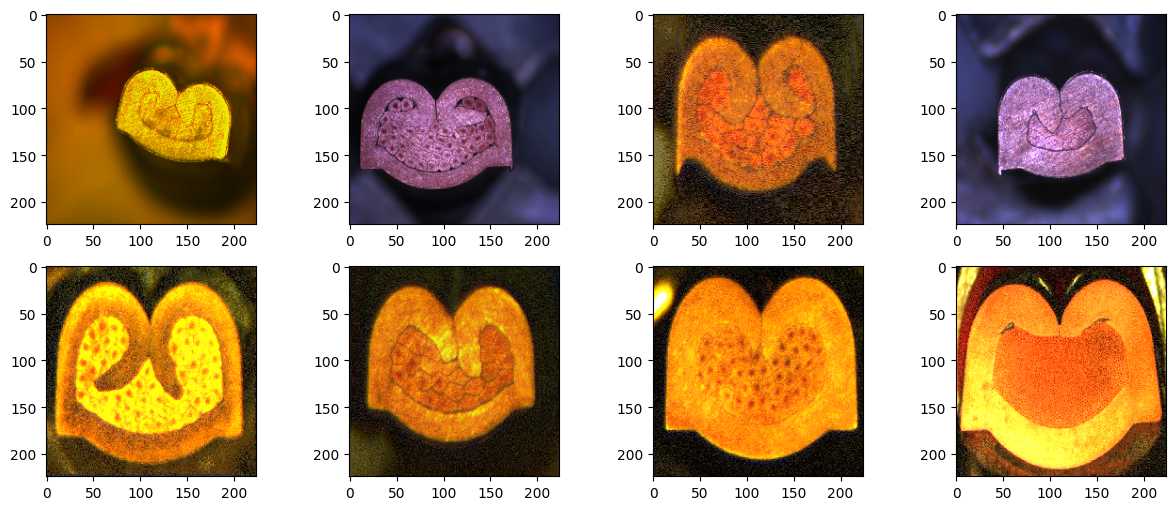

In [10]:
# Get a batch of images from the generator
img_batch, _ = train_data.next()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_batch[i])
    ax.axis('on')
    
plt.show()

In [11]:
class_names = train_data.class_indices
class_names

{'NOK': 0, 'OK': 1}

In [12]:
# Get the class labels from the data generator
labels = train_data.classes

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=labels)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [13]:
class_weight_dict

{0: 1.0958781362007168, 1: 0.9195488721804511}

In [14]:
# Create a placeholder for the input layer
#input_layer = Input(shape=(img_width, img_height, 1))

# Replicate the single-channel input into three channels
#x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(input_layer)

In [15]:
base_model = DenseNet121(
        weights='imagenet', # Load pre-trained weights from the ImageNet dataset
        include_top=False, # Set to False to exclude the top fully connected layers from the model
        input_shape=(img_width,img_height,3) # The input shape of the images
    )

gmp = GlobalAveragePooling2D()(base_model.output)

output = Dense(1, activation='sigmoid')(gmp)

model = Model(base_model.input, outputs=output)

In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.src.engine.input_layer.InputLayer object at 0x00000174CC6AF0D0>,input_1,False
1,<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x00000174CC9BD2A0>,zero_padding2d,False
2,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x00000174CC96CB50>,conv1/conv,False
3,<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x00000174CC9DAD70>,conv1/bn,False
4,<keras.src.layers.core.activation.Activation object at 0x00000174CC9DBB50>,conv1/relu,False
...,...,...,...
424,<keras.src.layers.merging.concatenate.Concatenate object at 0x00000174CE67D7B0>,conv5_block16_concat,False
425,<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x00000174EE1C7550>,bn,False
426,<keras.src.layers.core.activation.Activation object at 0x00000174CAF72890>,relu,False
427,<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x00000174C8CDB370>,global_average_pooling2d,True


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [19]:
recall = Recall()
precision = Precision()

In [20]:
optimizer = SGD(learning_rate=0.01)
#optimizer = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [21]:
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [22]:
EPOCHS = 10

history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb],
                      class_weight=class_weight_dict
                  )

Epoch 1/10


152/152 [==============================] - 26s 150ms/step - loss: 0.6909 - accuracy: 0.6329 - recall: 0.6369 - precision: 0.6715 - val_loss: 0.5473 - val_accuracy: 0.7467 - val_recall: 0.6025 - val_precision: 0.8818
Epoch 2/10
152/152 [==============================] - 23s 150ms/step - loss: 0.5173 - accuracy: 0.7374 - recall: 0.7511 - precision: 0.7638 - val_loss: 0.4875 - val_accuracy: 0.7730 - val_recall: 0.6790 - val_precision: 0.8661
Epoch 3/10
152/152 [==============================] - 25s 165ms/step - loss: 0.4666 - accuracy: 0.7926 - recall: 0.8030 - precision: 0.8129 - val_loss: 0.4234 - val_accuracy: 0.8355 - val_recall: 0.8313 - val_precision: 0.8526
Epoch 4/10
152/152 [==============================] - 24s 160ms/step - loss: 0.4029 - accuracy: 0.8263 - recall: 0.8348 - precision: 0.8438 - val_loss: 0.3937 - val_accuracy: 0.8421 - val_recall: 0.8813 - val_precision: 0.8294
Epoch 5/10
152/152 [==============================] - 24s 157ms/step - loss: 0.3889 - accu

In [23]:
len(base_model.layers)

427

In [24]:
base_model.trainable = True
# Freeze the first 100 layers 
for layer in base_model.layers:
  layer.trainable = False

In [25]:
for layer in base_model.layers:
  layer.trainable = True

In [26]:
optimizer = SGD(learning_rate=0.001)
#optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [27]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
df 

,Layer Type,Layer Name,Layer Trainable
0,<keras.src.engine.input_layer.InputLayer object at 0x00000174CC6AF0D0>,input_1,True
1,<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x00000174CC9BD2A0>,zero_padding2d,True
2,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x00000174CC96CB50>,conv1/conv,True
3,<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x00000174CC9DAD70>,conv1/bn,True
4,<keras.src.layers.core.activation.Activation object at 0x00000174CC9DBB50>,conv1/relu,True
...,...,...,...
424,<keras.src.layers.merging.concatenate.Concatenate object at 0x00000174CE67D7B0>,conv5_block16_concat,True
425,<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x00000174EE1C7550>,bn,True
426,<keras.src.layers.core.activation.Activation object at 0x00000174CAF72890>,relu,True
427,<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x00000174C8CDB370>,global_average_pooling2d,True


In [28]:
df['Layer Trainable'].value_counts()[True]

429

In [29]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [30]:
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [31]:
checkpoint_cb = ModelCheckpoint('DenseNet121-1.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')

In [32]:
#csv_logger = CSVLogger('training_log2.csv')

In [33]:
EPOCHS = 100

history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb,checkpoint_cb,reduce_lr_cb],
                      class_weight=class_weight_dict
                   )

Epoch 1/100
152/152 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.7745 - recall: 0.6993 - precision: 0.8693

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


152/152 [==============================] - 71s 420ms/step - loss: 0.5068 - accuracy: 0.7745 - recall: 0.6993 - precision: 0.8693 - val_loss: 0.8263 - val_accuracy: 0.6776 - val_recall: 1.0000 - val_precision: 0.6202 - lr: 0.0010
Epoch 2/100
152/152 [==============================] - 64s 420ms/step - loss: 0.2438 - accuracy: 0.8922 - recall: 0.8953 - precision: 0.9049 - val_loss: 0.3312 - val_accuracy: 0.8586 - val_recall: 0.9877 - val_precision: 0.7970 - lr: 0.0010
Epoch 3/100
152/152 [==============================] - 64s 418ms/step - loss: 0.1702 - accuracy: 0.9383 - recall: 0.9378 - precision: 0.9479 - val_loss: 0.1202 - val_accuracy: 0.9507 - val_recall: 0.9753 - val_precision: 0.9349 - lr: 0.0010
Epoch 4/100
152/152 [==============================] - 64s 419ms/step - loss: 0.1193 - accuracy: 0.9613 - recall: 0.9636 - precision: 0.9651 - val_loss: 0.0747 - val_accuracy: 0.9770 - val_recall: 0.9874 - val_precision: 0.9691 - lr: 0.0010
Epoch 5/100
152/152 [===========================

In [34]:
def visualize_training_results(results):
    history = results.history
    
    # Find the epoch where validation accuracy was highest
    best_epoch = np.argmin(history['val_loss'])
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best epoch')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show()

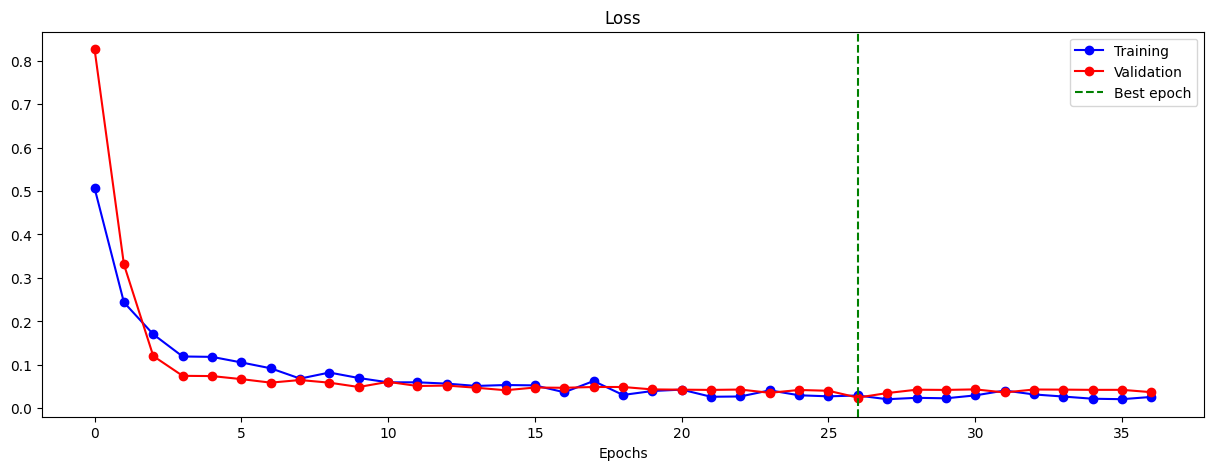

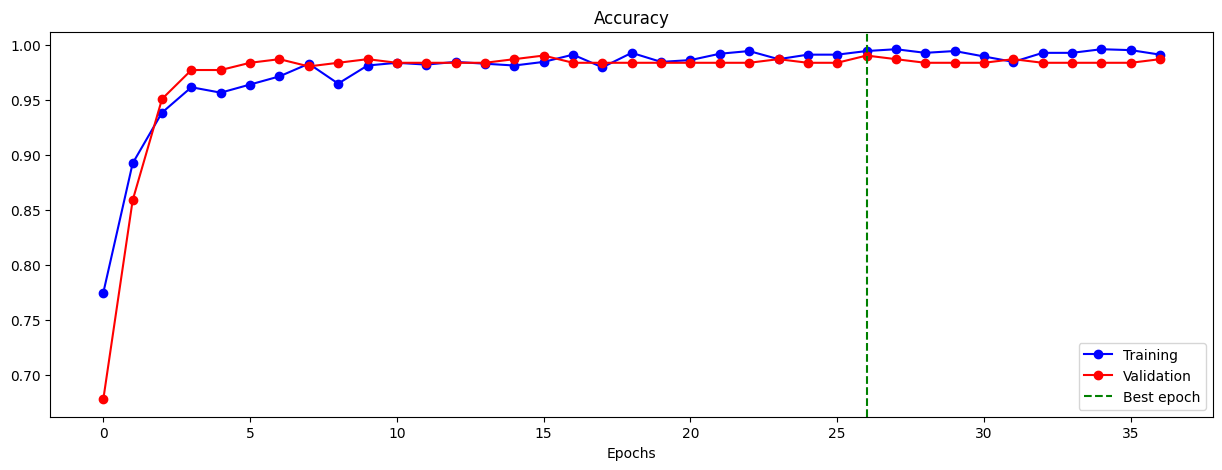

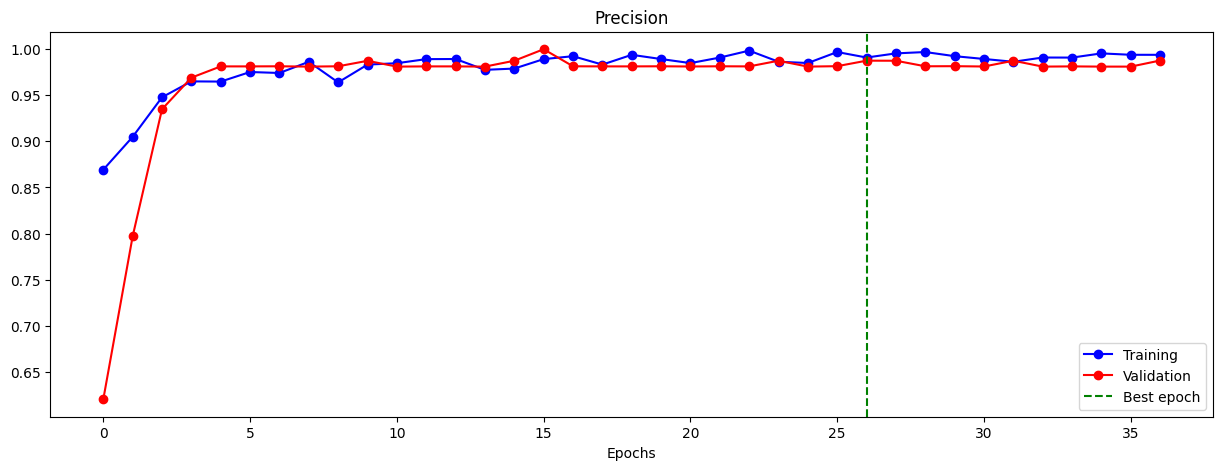

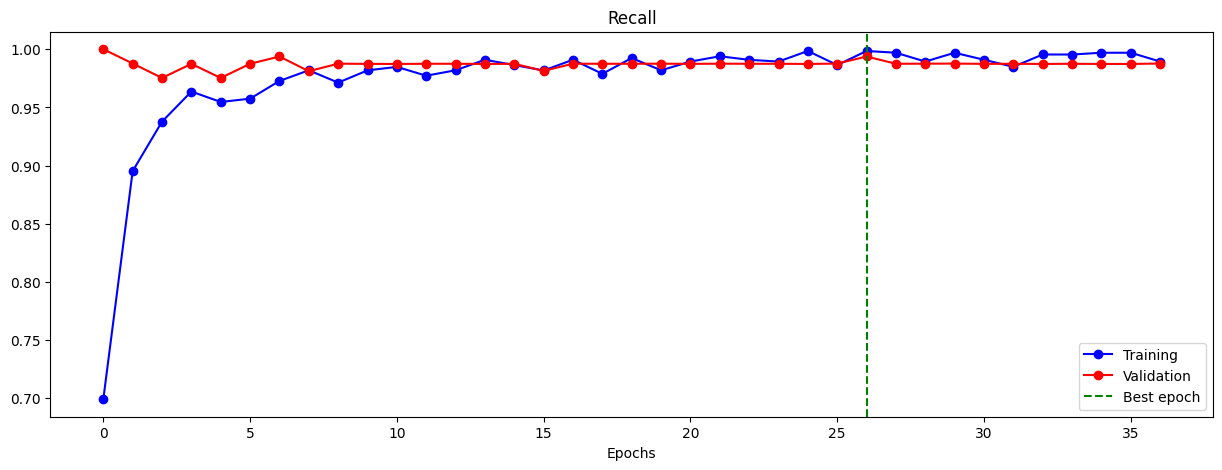

In [35]:
visualize_training_results(history)

In [36]:
def plot_metrics(model, test_data):
    # Get the predicted labels and true labels
    y_pred = model.predict(test_data)
    y_pred = y_pred > 0.5
    y_true = test_data.labels

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['NO OK', 'OK'])
    ax1.yaxis.set_ticklabels(['NO OK', 'OK'])

    # Calculate the true positive rate (TPR) and false positive rate (FPR) at different thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax2.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')

    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    plt.show()
    
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    # Print the report
    print(report)


20/20 [==============================] - 3s 123ms/step


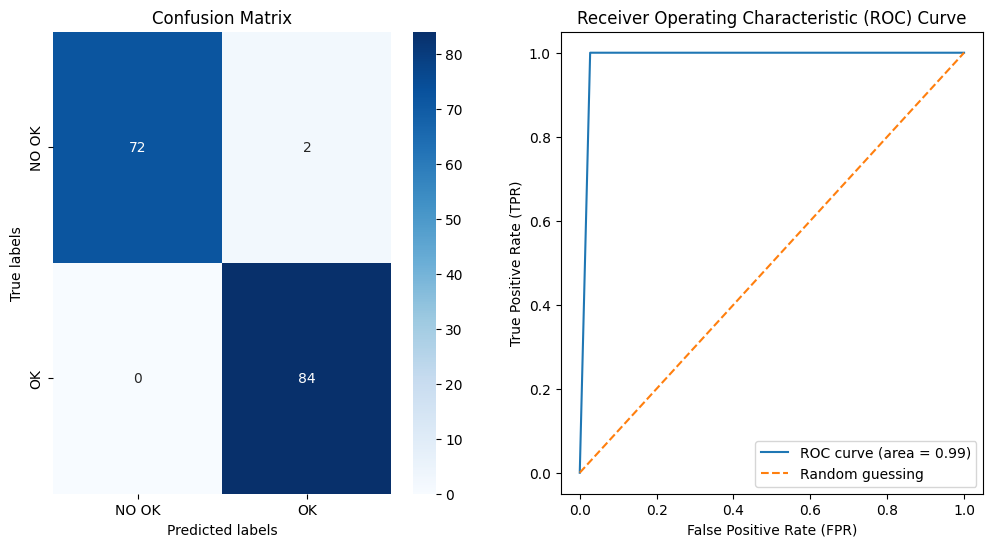

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        74
           1       0.98      1.00      0.99        84

    accuracy                           0.99       158
   macro avg       0.99      0.99      0.99       158
weighted avg       0.99      0.99      0.99       158



In [37]:
plot_metrics(model, test_data)

In [38]:
# Print the metrics of the best epoch
best_epoch = np.argmin(history.history['val_loss'])
print("Best epoch: ", best_epoch)
print("Best loss: ", history.history['loss'][best_epoch])
print("Best accuracy: ", history.history['accuracy'][best_epoch])
print("Best recall: ", history.history['recall'][best_epoch])
print("Best precision: ", history.history['precision'][best_epoch])
print("Best val_loss: ", history.history['val_loss'][best_epoch])
print("Best val_accuracy: ", history.history['val_accuracy'][best_epoch])
print("Best val_recall: ", history.history['val_recall'][best_epoch])
print("Best val_precision: ", history.history['val_precision'][best_epoch])

Best epoch:  26
Best loss:  0.029470354318618774
Best accuracy:  0.9942386746406555
Best recall:  0.998487114906311
Best precision:  0.9909909963607788
Best val_loss:  0.024645837023854256
Best val_accuracy:  0.9901315569877625
Best val_recall:  0.9937499761581421
Best val_precision:  0.9875776171684265
